# Project Information

**Name:** Anshul Yadav  
**Matriculation Number:** G2504792G  
**Dataset:** Wisconsin Breast Cancer Dataset  

---

## Data Cleaning
- Normalization  
- Removal of highly correlated features  

---

## Machine Learning Techniques
- K-Fold Cross Validation  
- Logistic Regression
- Artificial Neural Network (ANN)  
  - L2 Regularization  
  - Dropout  
- Binary Cross Entropy Loss  
- Geometric Learning Rate Schedule with Adam Optimizer  

---

## AI Assistance
- ChatGPT:  
  - Assistance with ROC curve implementation  
  - Plotting code for:
    - Correlation Matrix  
    - ROC Curve  
    - Equal Error Rate (EER) line and point  
  - Equal Error Rate calculation


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from typing import NamedTuple, List
import keras
import tensorflow as tf
np.set_printoptions( precision=5, edgeitems=25, linewidth=200)

In [2]:
""" Read the dataset """
data = pd.read_csv("data.csv", header=0, index_col=0)
data["label"] = (data["diagnosis"] == "M").astype(int) # M = 1, "B" = 0
data = data.drop(columns=["diagnosis"])
data = data.astype('float32')


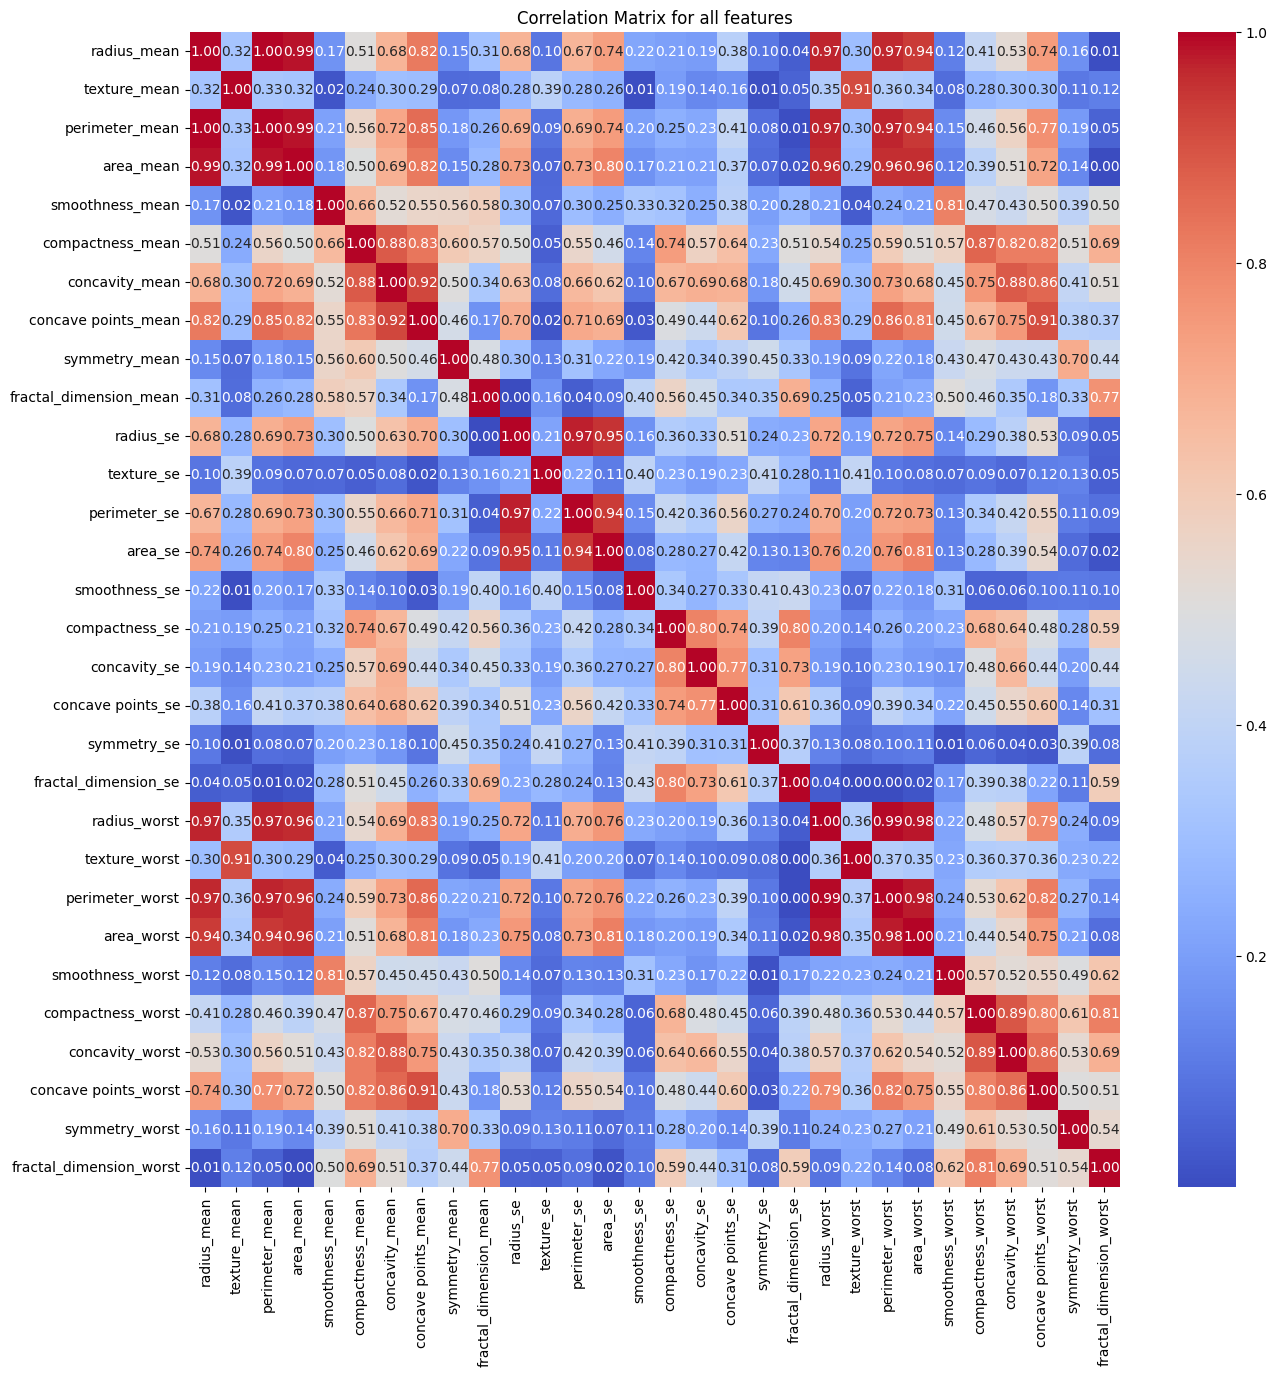

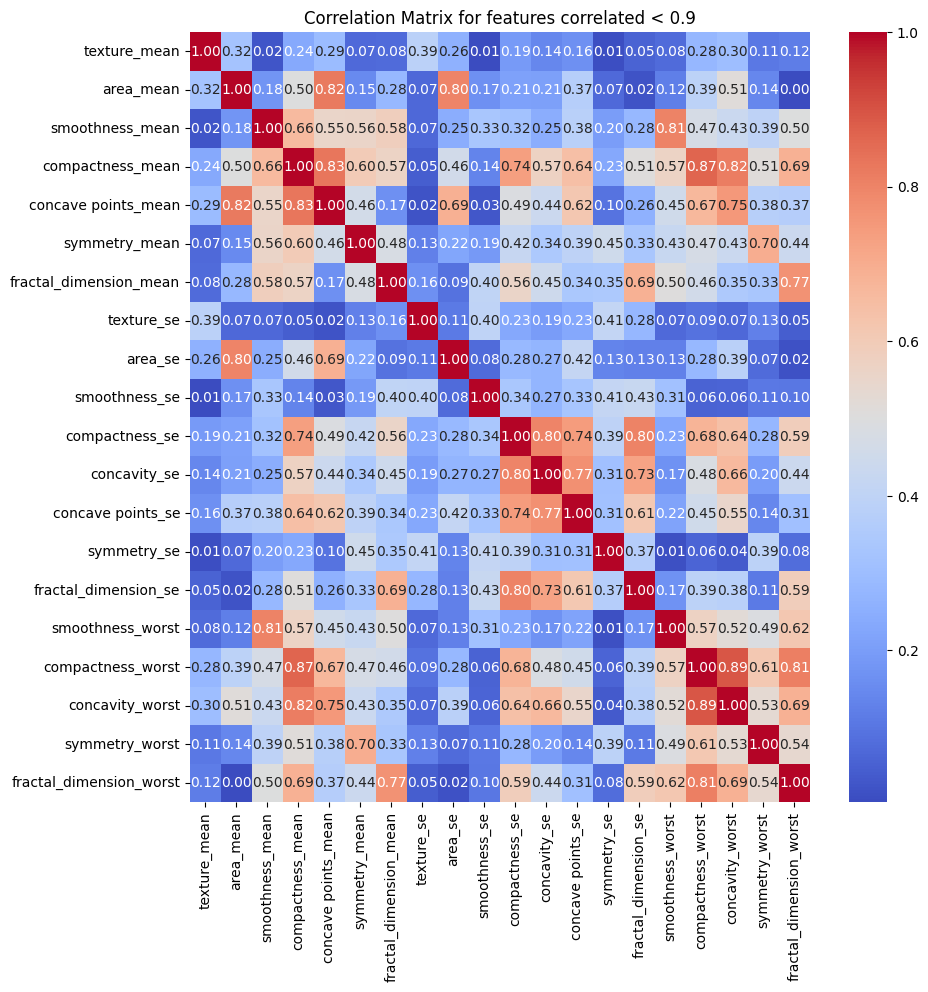

In [3]:
""" Normalizing Data """
# Normalize features except label
for col in data.columns:
    if col != "label":
        data[col] = (data[col] - data[col].mean()) / data[col].std()

""" Only keeping weakly correlated data """
corr_threshold = 0.9 # features with correlation over this threshold will be dropped. 
removed_cols = []

# Compute absolute correlation without label
corr = data.drop(columns=["label"]).corr().abs()

# # Plot heatmap
plt.figure(figsize=(15,15))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix for all features")
plt.show()

while True:
    # find the 2 most correlated features
    max_corr = 0
    max_row = -1
    max_col = -1

    for r in range(1, len(corr)): # 1 to L-1
        for c in range(r): # ) to r-1
            if corr.iloc[r,c] > max_corr:
                max_corr = corr.iloc[r,c]
                max_row = r
                max_col = c
            
    if max_corr < corr_threshold: break

    # compute the total corr for each feature
    total_row_corr = corr[ corr.columns[max_row] ].sum()
    total_col_corr = corr[ corr.columns[max_col] ].sum()

    if total_row_corr > total_col_corr:
        remove_col = corr.columns[max_row] 
    elif total_row_corr < total_col_corr:
        remove_col = corr.columns[max_col]
    else:
        raise NotImplementedError()
    removed_cols.append(remove_col)
    data = data.drop(columns= [remove_col])
    corr = data.drop(columns=["label"]).corr().abs()

plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title(f"Correlation Matrix for features correlated < {corr_threshold}")
plt.show()

In [4]:
""" Creating the training, validation and test sets """
# using a train/test split of 90/10, and a f_fold = 8
train_to_total_split = 0.9
k_fold = 10

class Fold(NamedTuple):
    train:pd.DataFrame
    validation:pd.DataFrame
    
train_df, test_df = train_test_split(data, train_size=train_to_total_split, random_state=42)  

kf = KFold(n_splits=k_fold, shuffle=True, random_state=42)  
folds:List[Fold] = []
for train_idx, valid_idx in kf.split(train_df):
    train = train_df.iloc[train_idx]
    validation = train_df.iloc[valid_idx]
    folds.append(Fold(train=train, validation=validation))

In [5]:
""" Supervised Training """
### Shallow Neural Network and Logistic Regression

input_size = len(data.columns) - 1 # discounting label
num_epochs = 150
iterations_per_fold = 25
total_iterations = num_epochs * k_fold * iterations_per_fold
lr_start = 0.0005
lr_end = 0.000001
batch_size = 64
regularization = keras.regularizers.l2(.05)

neural_network = keras.Sequential([
    keras.layers.Input(shape=(input_size,)),
    keras.layers.Dropout(rate = 0.3),
    keras.layers.Dense(2, kernel_regularizer= regularization, bias_regularizer=regularization),
    keras.layers.LeakyReLU(),
    keras.layers.Dropout(rate = 0.3),
    keras.layers.Dense(1, activation="sigmoid", kernel_regularizer=regularization, bias_regularizer=regularization)  # binary classification
], name="NEURAL_NETWORK")
neural_network.summary()
print("\n\n")
logistic_regression = keras.Sequential([
    keras.layers.Input(shape=(input_size,)),
    keras.layers.Dense(1, activation="sigmoid", kernel_regularizer=regularization, bias_regularizer=regularization)
], name="LOGISTIC_REGRESSION")
logistic_regression.summary()

# Using a customized LR schedule that is geometrically spaced instead of linearly spaced
class GeometricLRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, lr_start, lr_end, total_steps):
        super().__init__()
        self.lr_start = lr_start
        self.lr_end = lr_end
        self.total_steps = total_steps
        # compute geometric ratio
        self.r = (lr_end / lr_start) ** (1 / (total_steps - 1))

    def __call__(self, step):
        return self.lr_start * (self.r ** step)

loss_fn = keras.losses.BinaryCrossentropy(from_logits=False)
lr_schedule = GeometricLRSchedule(lr_start, lr_end, total_iterations)
nn_optimizer = keras.optimizers.legacy.Adam(lr_schedule)
lr_optimizer = keras.optimizers.legacy.Adam(lr_schedule)


Model: "NEURAL_NETWORK"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense (Dense)               (None, 2)                 42        
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 2)                 0         
                                                                 
 dropout_1 (Dropout)         (None, 2)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 3         
                                                                 
Total params: 45 (180.00 Byte)
Trainable params: 45 (180.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________



Model: "LOGIS

In [6]:
""" Training the Logsitic Regression and Neiral Net"""
# Prepare test data
test_X = test_df.drop(columns=["label"]).to_numpy()
test_y = test_df["label"].to_numpy().reshape(-1, 1)

nn_val_losses = []
nn_test_losses = []

lr_val_losses = []
lr_test_losses = []

for epoch in range(1, num_epochs+1):
    # print(f"\nEpoch {epoch}/{num_epochs}")

    nn_val_loss = []  # list to accumulate neural network validation losses for this epoch
    lr_val_loss = []  # list to accumulate logistic regression validation losses for this epoch

    for fold_idx in range(k_fold):
        fold = folds[fold_idx]
        train, validation = fold

        # Prepare validation data once per fold
        val_X = validation.drop(columns=["label"]).to_numpy()
        val_y = validation["label"].to_numpy().reshape(-1, 1)

        # Mini-batch training
        for iteration in range(iterations_per_fold):
            mini_batch = train.sample(batch_size, replace=True)
            x_batch = mini_batch.drop(columns=["label"]).to_numpy()
            y_batch = mini_batch["label"].to_numpy().reshape(-1, 1)

            with tf.GradientTape() as nn_tape:
                logits = neural_network(x_batch, training=True)
                nn_loss_value = loss_fn(y_batch, logits)

            grads = nn_tape.gradient(nn_loss_value, neural_network.trainable_weights)
            nn_optimizer.apply_gradients(zip(grads, neural_network.trainable_weights))
            
            with tf.GradientTape() as lr_tape:
                logits = logistic_regression(x_batch, training=True)
                lr_loss_value = loss_fn(y_batch, logits)

            grads = lr_tape.gradient(lr_loss_value, logistic_regression.trainable_weights)
            lr_optimizer.apply_gradients(zip(grads, logistic_regression.trainable_weights))

        # Validation loss for this fold
        val_logits = neural_network(val_X, training=False)
        nn_val_loss.append( loss_fn(val_y, val_logits).numpy() )
        
        val_logits = logistic_regression(val_X, training=False)
        lr_val_loss.append( loss_fn(val_y, val_logits).numpy() )

    # Average validation loss across folds
    avg_nn_val_loss = np.mean(nn_val_loss)
    nn_val_losses.append(avg_nn_val_loss)

    avg_lr_val_loss = np.mean(lr_val_loss)
    lr_val_losses.append(avg_lr_val_loss)
    
    # Inside the epoch loop, after computing avg_val_loss
    test_logits = neural_network(test_X, training=False)
    test_loss = loss_fn(test_y, test_logits).numpy()
    nn_test_losses.append(test_loss)

    test_logits_lr = logistic_regression(test_X, training=False)
    test_loss_lr = loss_fn(test_y, test_logits_lr).numpy()
    lr_test_losses.append(test_loss_lr)

    # print(f"Neural Net: Validation Loss={avg_nn_val_loss:.4f}, Test Loss={test_loss:.4f}")
    # print(f"Logstic Regression: Validation Loss={avg_lr_val_loss:.4f}, Test Loss={test_loss_lr:.4f}")


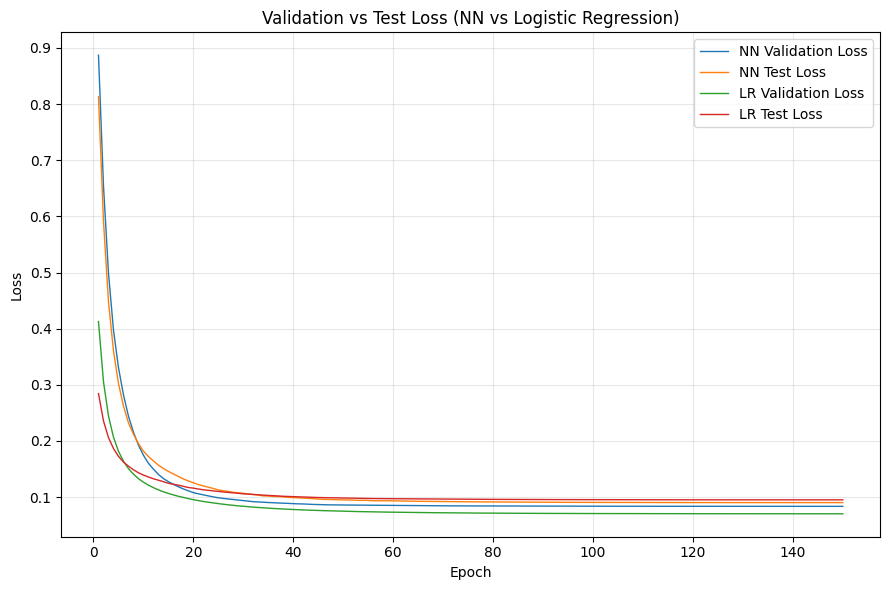

In [7]:
""" Plotting Loss for Validation and Test Sets"""
nn_val = np.asarray(nn_val_losses)
nn_test = np.asarray(nn_test_losses)
lr_val = np.asarray(lr_val_losses)
lr_test = np.asarray(lr_test_losses)

epochs = np.arange(1, num_epochs + 1)

plt.figure(figsize=(9,6))
plt.plot(epochs, nn_val, label="NN Validation Loss", linewidth=1)
plt.plot(epochs, nn_test, label="NN Test Loss",  linewidth=1)
plt.plot(epochs, lr_val, label="LR Validation Loss",  linewidth=1)
plt.plot(epochs, lr_test, label="LR Test Loss",linewidth=1)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation vs Test Loss (NN vs Logistic Regression)")
plt.legend(loc="best")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



Neural Net Best Threshold: 0.13131424202812259
Neural Net TPR at Best Threshold: 0.9411764705882353
Neural Net FPR at Best Threshold: 0.05

Logistic Regression Best Threshold: 0.16110933760576004
Logistic Regression TPR at Best Threshold: 0.9411764705882353
Logistic Regression FPR at Best Threshold: 0.05

Neural Net AUROC: 0.995588
Logistic Regression AUROC: 0.989706

Since the Neural Net AUROC is slightly higher than that of the Logistic Regressor, it is a slightly better classifier.



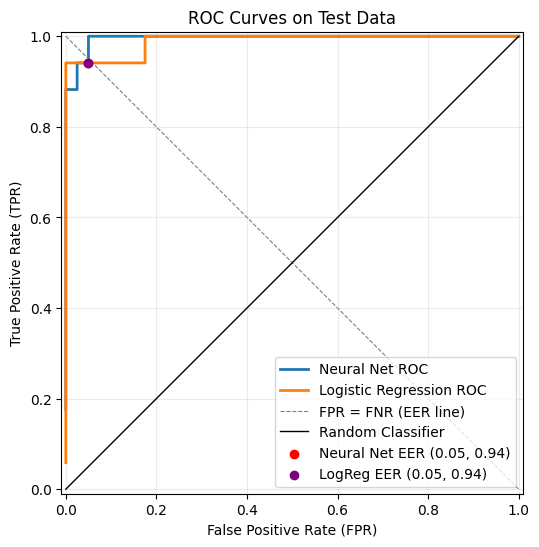

In [8]:
""" Plotting ROC curve for both Regressors"""
def compute_tpr_fpr(probs, test_y, thresholds):
    """
    Compute TPR and FPR arrays for a set of thresholds given predicted probabilities and true labels.

    Returns:
        TPR (np.ndarray), FPR (np.ndarray)
    """
    probs = np.asarray(probs).ravel()
    test_y = np.asarray(test_y).ravel().astype(np.float32)

    TPR = []
    FPR = []

    for threshold in thresholds:
        preds = (probs >= threshold).astype(np.float32)

        TP = np.sum((preds == 1.0) & (test_y == 1.0))
        FP = np.sum((preds == 1.0) & (test_y == 0.0))
        TN = np.sum((preds == 0.0) & (test_y == 0.0))
        FN = np.sum((preds == 0.0) & (test_y == 1.0))

        TPR.append(TP / (TP + FN) if (TP + FN) != 0 else 0)
        FPR.append(FP / (TN + FP) if (TN + FP) != 0 else 0)

    return np.array(TPR), np.array(FPR)

thresholds = np.geomspace(1e-8, 1.0, 10000)

# Neural net stats
nn_probs = neural_network(test_X, training=False).numpy().ravel()
nn_TPR, nn_FPR = compute_tpr_fpr(nn_probs, test_y, thresholds)
nn_eer_proxy = np.abs(nn_FPR - (1 - nn_TPR))  # |FPR - FNR|
nn_best_indx = np.argmin(nn_eer_proxy)

print(f"Neural Net Best Threshold: {thresholds[nn_best_indx]}")
print(f"Neural Net TPR at Best Threshold: {nn_TPR[nn_best_indx]}")
print(f"Neural Net FPR at Best Threshold: {nn_FPR[nn_best_indx]}")
print()
# Logistic Regression stats
lr_probs = logistic_regression(test_X, training=False).numpy().ravel()
lr_TPR, lr_FPR = compute_tpr_fpr(lr_probs, test_y, thresholds)
lr_eer_proxy = np.abs(lr_FPR - (1 - lr_TPR))  # |FPR - FNR|
lr_best_indx = np.argmin(lr_eer_proxy)

print(f"Logistic Regression Best Threshold: {thresholds[lr_best_indx]}")
print(f"Logistic Regression TPR at Best Threshold: {lr_TPR[lr_best_indx]}")
print(f"Logistic Regression FPR at Best Threshold: {lr_FPR[lr_best_indx]}")
print()
# Use sorted arrays for AUROC calculations
nn_sorted_FPR = nn_FPR[::-1]
nn_sorted_TPR = nn_TPR[::-1]

lr_sorted_FPR = lr_FPR[::-1]
lr_sorted_TPR = lr_TPR[::-1]

nn_auc_trap = np.trapz(nn_sorted_TPR, nn_sorted_FPR)
lr_auc_trap = np.trapz(lr_sorted_TPR, lr_sorted_FPR)

print(f"Neural Net AUROC: {nn_auc_trap:.6f}")
print(f"Logistic Regression AUROC: {lr_auc_trap:.6f}")
print()
print("Since the Neural Net AUROC is slightly higher than that of the Logistic Regressor, it is a slightly better classifier.")
print()

""" Plotting """
plt.figure(figsize=(6.5,6))

# ROC curves
plt.plot(nn_sorted_FPR, nn_sorted_TPR, label="Neural Net ROC", linewidth=2)
plt.plot(lr_sorted_FPR, lr_sorted_TPR, label="Logistic Regression ROC", linewidth=2)

# dashed line where FPR == FNR (i.e. TPR = 1 - FPR)
plt.plot([0, 1], [1, 0], linestyle='--', linewidth=0.8, color='gray', label='FPR = FNR (EER line)')

# Random Classifier: diagonal (chance)
plt.plot([0, 1], [0, 1], linestyle='-', linewidth=1.0, color='black', label='Random Classifier')

# EER Points (use the original indices)
plt.scatter(nn_FPR[nn_best_indx], nn_TPR[nn_best_indx], color='red', zorder=5,
            label=f"Neural Net EER ({nn_FPR[nn_best_indx]:.2f}, {nn_TPR[nn_best_indx]:.2f})")
plt.scatter(lr_FPR[lr_best_indx], lr_TPR[lr_best_indx], color='purple', zorder=5,
            label=f"LogReg EER ({lr_FPR[lr_best_indx]:.2f}, {lr_TPR[lr_best_indx]:.2f})")

plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curves on Test Data')
plt.legend(loc='lower right')
plt.grid(alpha=0.25)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
